# Evaluate Unit-wget model over MPI and Era

This notebook evaluates different CNN autoencoder models on things like 1) monthly averages and 2) climate. The selected model tries to bias correct Mpi to Era and Era to MPI.

### TOC
 [1. Model Select](#ms)<br>
 [2. Load data](#ld)<br>
 [3. Simple tiling](#st)<br>
 [4. Simple - Filterred](#sf)<br>
 





In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
bce = nn.BCELoss()
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy


In [3]:
# define internal pic res
ires = 128
res = 128
nvars = 16
mnvars = 16


In [4]:
 mnvars

16

<a id='ms'></a>
## Models: run one from below:


In [5]:
import torch.nn.functional as F

In [43]:
class Conv2dBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero'):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'lonwrap':
            self.pad = LatLonPad(padding, lon_dim=-1)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            #self.norm = nn.InstanceNorm2d(norm_dim, track_running_stats=True)
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        self.activation = MultiChannelActivation(activation, output_dim)

        # initialize convolution
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias)

    def forward(self, x):
        #print("x", x)
        #print("SHAPE1 x", x.shape)
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x


class Encoder(nn.Module):
    def __init__(self, n_downsample, n_res, input_dim, dim, norm, activ, pad_type):
        super(Encoder, self).__init__()
        #input_dim, output_dim, kernel_size, stride, padding
        # This layer conserves lat-lon
        self.model = [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        # downsampling blocks
        for i in range(n_downsample):
            # This layer coarsens lat-lon by factor 2
            self.model += [
                Conv2dBlock(dim, 2*dim,
                            kernel_size=4, stride=2, padding=1,
                            norm=norm, activation=activ, pad_type=pad_type)
            ]
            # residual blocks maintain lat-lon shape
            if n_res>0:
                self.model += [ResBlocks(n_res, 2*dim, norm='none', activation=activ, pad_type=pad_type)]
            dim *= 2

        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_upsample, n_res, dim, output_dim, norm,
                 activ='relu', pad_type='zero', output_activ='none', upsample='nearest'):
        super(Decoder, self).__init__()

        if upsample=='nearest':
            def _decode_upsampler(C): return nn.Upsample(scale_factor=2, mode='nearest')
        elif upsample=='bilinear':
            def _decode_upsampler(C): return nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        elif upsample=='conv':
            def _decode_upsampler(C): return nn.ConvTranspose2d(C, C, kernel_size=2, stride=2)
        else:
            assert 0, "`upsample` must be one of ['nearest', 'bilinear', 'conv']"

        self.model = []
        # residual blocks
        if n_res>0:
            self.model += [ResBlocks(n_res, dim, norm, activ, pad_type=pad_type)]
        # upsampling blocks
        for i in range(n_upsample):
            self.model += [_decode_upsampler(dim)]
            self.model += [Conv2dBlock(dim, dim//2, 5, 1, 2,
                                       norm=norm, activation=activ, pad_type=pad_type)]
            if n_res>0:
                self.model += [ResBlocks(n_res, dim//2, norm='none', activation=activ, pad_type=pad_type)]
            dim //= 2

        self.model += [Conv2dBlock(dim, output_dim, 7, 1, 3, norm='none', activation=output_activ, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)


    def forward(self, x):
        return self.model(x)

def get_activation(activation):
        # initialize activation
    if activation == 'relu':
        return nn.ReLU(inplace=False)
    elif activation == '-relu':
        return NegReLU()
    elif activation == 'lrelu':
        return nn.LeakyReLU(0.2, inplace=True)
    elif activation == 'prelu':
        return nn.PReLU()
    elif activation == 'selu':
        return nn.SELU(inplace=True)
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'none':
        return None
    else:
        assert 0, "Unsupported activation: {}".format(activation)

    
class MultiChannelActivation(nn.Module):
    def __init__(self, activation, output_dim):
        super(MultiChannelActivation, self).__init__()
        if isinstance(activation, str):
            activation = [activation]
        elif (not isinstance(activation, list)) or len(activation)!=output_dim:
            raise ValueError(f"Not valid activation {activation} for channels {output_dim}")

        self.activation = [get_activation(a) for a in activation]

    def forward(self, x):
        if len(self.activation)==1:
            if self.activation[0] is not None:
                return self.activation[0](x)
            else:
                return x
        else:
            x_list = [self.activation[i](x[:, i:i+1]) if self.activation[i] is not None else x[:, i:i+1] for i in range(x.shape[1])]
            x = torch.cat(x_list, dim=1)
            return x

##################################################################################
# Sequential Models
##################################################################################

class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='lrelu', pad_type='zero'):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)


##################################################################################
# Basic Blocks
##################################################################################

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='lrelu', pad_type='zero'):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim, dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        model += [Conv2dBlock(dim, dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = residual + self.model(x)
        return out


  
    
class VAEGen(nn.Module):
    # VAE architecture
    def __init__(self, input_dim, land_mask, params):
        super(VAEGen, self).__init__()
        dim = params['dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']
        output_activ = 'none' #params['output_activ']
        upsample = 'nearest' #params['upsample']
        norm = 'bn' #params['norm']
        self.use_land_mask = land_mask is not None
        self.land_mask = nn.Parameter(land_mask, requires_grad=False)

        # content encoder
        self.enc = Encoder(n_downsample, n_res, input_dim+int(self.use_land_mask),
                                  dim, norm, activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc.output_dim, input_dim, norm=norm,
                           activ=activ, pad_type=pad_type, output_activ=output_activ,
                           upsample=upsample)

    def forward(self, images):
        # This is a reduced VAE implementation where we assume the outputs are multivariate Gaussian distribution with mean = hiddens and std_dev = all ones.
        hiddens = self.encode(images)
        if 0 and self.training:
            #print("hiddens", hiddens)
            #noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
            noise = Variable(torch.randn(hiddens.size()))
            images_recon = self.decode(hiddens + noise)
        else:
            images_recon = self.decode(hiddens)
        return images_recon, hiddens

    def encode(self, images):
        if self.use_land_mask:
            images = torch.cat([images, self.land_mask.clone().detach().repeat(images.shape[0],1,1,1)], dim=1)
        hiddens = self.enc(images)
        #noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
        noise = Variable(torch.randn(hiddens.size()))
        return hiddens, noise
    
    def decode(self, hiddens):
        images = self.dec(hiddens)
        return images
    
##################################################################################
# Discriminator
##################################################################################

class MsImageDis(nn.Module):
    # Multi-scale discriminator architecture
    def __init__(self, input_dim, land_mask, params):
        super(MsImageDis, self).__init__()
        self.n_layer = params['n_layer']
        self.gan_type = params['gan_type']
        self.dim = params['dim']
        self.norm = params['norm']
        self.activ = params['activ']
        self.num_scales = params['num_scales']
        self.pad_type = params['pad_type']

        self.input_dim = input_dim
        self.use_land_mask = land_mask is not None
        self.land_mask = nn.Parameter(land_mask, requires_grad=False)
        self.downsample = nn.AvgPool2d(2, stride=2, padding=0, count_include_pad=False)

        self.cnns = nn.ModuleList()
        for _ in range(self.num_scales):
            self.cnns.append(self._make_net())

    def _make_net(self):
        dim = self.dim
        cnn_x = [
            Conv2dBlock(
                (self.input_dim+int(self.use_land_mask)), dim, 7, 1, 3,
                norm='none',
                activation=self.activ,
                pad_type=self.pad_type),
            Conv2dBlock(dim, dim, 4, 2, 1,
              norm=self.norm,
              activation=self.activ,
              pad_type=self.pad_type)
        ]
        for i in range(self.n_layer  - 1):
            cnn_x += [Conv2dBlock(dim, dim * 2, 4, 2, 1,
                                  norm=self.norm,
                                  activation=self.activ,
                                  pad_type=self.pad_type)
            ]
            dim *= 2
        cnn_x += [nn.Conv2d(dim, 1, 1, 1, 0)]
        cnn_x = nn.Sequential(*cnn_x)
        return cnn_x

    def forward(self, x):
        outputs = []
        if self.use_land_mask:
            x = torch.cat([x, self.land_mask.clone().detach().repeat(x.shape[0],1,1,1)], dim=1)
        #print('SELF.CNNS', self.cnns)
        for model in self.cnns:
            #print('OIOIH', model, x)
            model.cuda()
            #x.cuda()
            #print(model(x))
            outputs.append(model(x))
            x = self.downsample(x)
        return outputs

    def calc_dis_loss(self, input_fake, input_real):
        # calculate the loss to train D
        outs0 = self.forward(input_fake)
        outs1 = self.forward(input_real)
        loss = 0

        for it, (out0, out1) in enumerate(zip(outs0, outs1)):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 0)**2) + torch.mean((out1 - 1)**2)
            elif self.gan_type == 'nsgan':
                all0 = Variable(torch.zeros_like(out0.data).cuda(), requires_grad=False)
                all1 = Variable(torch.ones_like(out1.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all0) +
                                   F.binary_cross_entropy(F.sigmoid(out1), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

    def calc_gen_loss(self, input_fake):
        # calculate the loss to train G
        outs0 = self.forward(input_fake)
        loss = 0
        for it, (out0) in enumerate(outs0):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 1)**2) # LSGAN
            elif self.gan_type == 'nsgan':
                all1 = Variable(torch.ones_like(out0.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss


    
def resume(checkpoint_dir, hyperparameters):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen")
        state_dict = torch.load(last_model_name)
        gen_a.load_state_dict(state_dict['a'])
        gen_b.load_state_dict(state_dict['b'])
        iterations = int(last_model_name[-11:-3])
        # Load discriminators
        last_model_name = get_model_list(checkpoint_dir, "dis")
        state_dict = torch.load(last_model_name)
        dis_a.load_state_dict(state_dict['a'])
        dis_b.load_state_dict(state_dict['b'])
        # Load optimizers
        state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
        dis_opt.load_state_dict(state_dict['dis'])
        gen_opt.load_state_dict(state_dict['gen'])
        ## Reinitilize schedulers
        #dis_scheduler = get_scheduler(dis_opt, hyperparameters, iterations)
        #gen_scheduler = get_scheduler(gen_opt, hyperparameters, iterations)
        print('Resume from iteration %d' % iterations)
        return iterations


# # Config
# #import yaml
# #with open('hadgem3_to_cam5_nat-hist-4channels.yaml', 'r') as stream:
# #        config = yaml.load(stream)
# gen = {'dim': 64, 'mlp_dim': 256, 'style_dim': 8, 'activ': 'relu', 'n_downsample': 2, 'n_res': 4, 'pad_type': 'zero'}
# dis = {'dim': 64, 'norm': 'none', 'activ': 'lrelu', 'n_layer': 4, 'gan_type': 'lsgan', 'num_scales': 3, 'pad_type': 'reflect'}



# # load generator
# gen_a = VAEGen(64, None, gen) 
# gen_b = VAEGen(64, None, gen) 
# state_dict = torch.load('/glade/scratch/dkorytin/delme/gen_00945001.pt', map_location=torch.device('cpu'))
# gen_a.load_state_dict(state_dict['a'])
# gen_b.load_state_dict(state_dict['b'])

# # load discriminator
# state_dict = torch.load('/glade/scratch/dkorytin/delme/dis_00945001.pt', map_location=torch.device('cpu'))
# dis_a = MsImageDis(64, None, dis)  # discriminator for domain a
# dis_a.load_state_dict(state_dict['a'])

In [140]:
# DEEPER 64x64 net
gen = {'dim': 64, 'mlp_dim': 2048, 'style_dim': 8, 'activ': 'relu', 'n_downsample': 3, 'n_res': 4, 'pad_type': 'zero', 'upsample': 'conv'}
dis = {'dim': 64, 'norm': 'bn', 'activ': 'lrelu', 'n_layer': 4, 'gan_type': 'lsgan', 'num_scales': 3, 'pad_type': 'reflect'}

# load generator
gen_a = VAEGen(16, None, gen) 
gen_b = VAEGen(16, None, gen) 
state_dict = torch.load('/glade/scratch/dkorytin/delme/gen_00720001.pt', map_location=torch.device('cpu'))
gen_a.load_state_dict(state_dict['a'])
gen_b.load_state_dict(state_dict['b'])


<All keys matched successfully>

<a id='ld'></a>
# Load data

In [45]:
# WRF-MPI DOMAIN Ext1
samples_era = torch.tensor(np.load('/glade/scratch/dkorytin/samples_wrferaext_with_orog_365.npy'), dtype=torch.float32)
samples_mpi = torch.tensor(np.load('/glade/scratch/dkorytin/samples_wrfmpiext_with_orog_365.npy'), dtype=torch.float32)

minmaxi_era = np.load('/glade/scratch/dkorytin/minmaxi_wrferaext_with_orog.npy')
minmaxi_mpi = minmaxi_era


In [12]:
samples_era.shape

torch.Size([365, 16, 192, 256])

(192, 256)


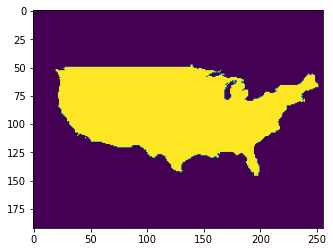

In [545]:
# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
mask.shape
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.
print(mask.shape)
plt.imshow(mask[::-1,:])

# # zero out mask borders in surface vars
# samples_mpi[:,8:,:,:] = samples_mpi[:,8:,:,:] * mask[None,None,:,:]
# samples_era[:,8:,:,:] = samples_era[:,8:,:,:] * mask[None,None,:,:]


# Plot routines

In [81]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import xarray as xr

# metadata used for lat/lon backdrop
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
dv1 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
    
def plot_8v_abs_192x256(isample, modelname, vmin, vmax, yoff=0, xoff=0, yz=192, xz=256, cc=True):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'PuBuGn', 'coolwarm', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))

    #vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    #vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))
    
    # min of Q850 should be 0
    vmin[2] = 0

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = dv1[0].lon
    lat = dv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
#         # add wind barbs
#         x=[]; y=[]; u=[]; v=[]
#         for mm in range(0, 128, 20):
#             hx = []
#             for nn in range(0, 128, 20): 
#                 x.append(dv1[0][mm,nn].lon)
#                 y.append(dv1[0][mm,nn].lat)
#                 #u.append(isample[11][mm,nn]) # uas
#                 #v.append(isample[12][mm,nn]) # vas
#                 u.append(isample[0][mm,nn]) # u850
#                 v.append(isample[1][mm,nn]) # v850
#         axarr[ii].barbs(x, y, u, v, length=5, sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5), linewidth=0.95)

#         # add huss850 contours
#         if cc == True:
#             x=[]; y=[];
#             for mm in range(0, 192, 1):
#                 x.append(dv1[0][mm,mm].lon)
#                 y.append(dv1[0][mm,mm].lat)
#             hx=[]; hy=[]
#             for mm in range(0, 192, 1):
#                 hx = []
#                 for nn in range(0, 256, 1):
#                     #hx.append(isample[2][mm,nn]) # q850
#                     hx.append(isample[ii][mm,nn]) # q850
#                 hy.append(hx)
#             X, Y = np.meshgrid(x, y)
#             Z = np.array(hy)
#             CS = axarr[ii].contour(X, Y, Z)
#             axarr[ii].clabel(CS, inline=True, fontsize=10)


        
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.26, fontsize=16)
    plt.show()





In [82]:
samples_era.shape

torch.Size([365, 16, 192, 256])

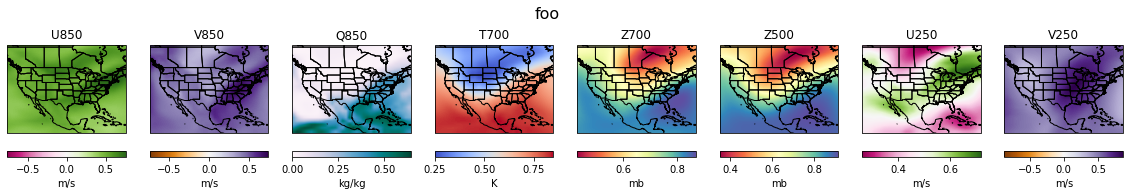

In [83]:
minmaxi_era
vmin = [samples_era[0][ii].min() for ii in range(16)]
vmax = [samples_era[0][ii].max() for ii in range(16)]

plot_8v_abs_192x256(np.array(samples_era[0]), 'foo', vmin, vmax)

In [ ]:
plot_8v_abs_192x256(np.array(samples_era[0]), 'foo', vmin, vmax)

In [84]:
# tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
# mask128 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(20,55), lon=slice(-130,-66))[:,12:12+128,69:69+128]
# mask128np = np.array(mask128[0])
# mask128np[mask128np>0] = 1
# mask128np[np.isnan(mask128np)] = 0.

# metadata used for lat/lon backdrop
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'
dv1 = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))

# gridmet as mask
tslice = slice('1979-01-01T00:00:00', '1979-01-01T20:00:00')
mask = xr.open_dataset('/glade/p/ral/risc/narccap/obs/gridMET/common/rsds.gridMET.NAM-22i.nc')['rsds'].sel(time=tslice, lat=slice(13.5,61.5), lon=slice(-130,-66))
mask.shape
mask = np.array(mask[0])
mask[mask>0] = 1
mask[np.isnan(mask)] = 0.


def plot_8v_abs_surf_192x256(isample, modelname, vmin, vmax, cc=True):

    varmames = ['prec', 'tmax', 'tmin', 'uas', 'vas', 'huss', 'miss', 'yday']
    units = ['mm/day', 'C', 'C', 'm/s', 'm/s', 'kg/kg', '0..1', '0..1']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['BrBG', 'RdBu_r', 'RdBu_r', 'PiYG', 'PuOr', 'BrBG', 'Spectral', 'Spectral']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    cmaps = ['YlGnBu', 'coolwarm', 'coolwarm', 'PiYG', 'PuOr', 'PuBuGn', 'Spectral', 'Spectral']

    # pass by value
    vmin = copy.deepcopy(vmin)
    vmax = copy.deepcopy(vmax)
    
    # Ranges centered on zero for U, V
    vmin[3+8] = -max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmax[3+8] = max(abs(vmin[3+8]), abs(vmax[3+8]))
    vmin[4+8] = -max(abs(vmin[4+8]), abs(vmax[4+8]))
    vmax[4+8] = max(abs(vmin[4+8]), abs(vmax[4+8]))
 
    # Ranges centered on zero for tmin, tmax
    vmin[1+8] = -max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmax[1+8] = max(abs(vmin[1+8]), abs(vmax[1+8]))
    vmin[2+8] = -max(abs(vmin[2+8]), abs(vmax[2+8]))
    vmax[2+8] = max(abs(vmin[2+8]), abs(vmax[2+8]))
    
    # prec min should be 0
    vmin[8] = 0

    # Plot borders
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    #lon = dv1[0].lon
    #lat = dv1[0].lat
    lon = dv1[0].lon
    lat = dv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        
        # add huss850 contours
        if cc == True:
            x=[]; y=[];
            for mm in range(0, 128, 1):
                x.append(dv1[0][mm,mm].lon)
                y.append(dv1[0][mm,mm].lat)
            hx=[]; hy=[]
            for mm in range(0, 128, 1):
                hx = []
                for nn in range(0, 128, 1):
                    #hx.append(isample[2][mm,nn]) # q850
                    hx.append(isample[ii+8][mm,nn]) # q850
                hy.append(hx)
            X, Y = np.meshgrid(x, y)
            Z = np.array(hy)
            CS = axarr[ii].contour(X, Y, Z)
            axarr[ii].clabel(CS, inline=True, fontsize=10)


        # mask
        if ii != 6:
            #image = isample[ii+8] * (1-dv15[0,:,:])
            image = isample[ii+8] * mask
            
        else:
            image = isample[ii+8] 
        
        plot = axarr[ii].imshow(image[::-1,:], vmin=vmin[ii+8], vmax=vmax[ii+8], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.26, fontsize=16)
    plt.show()


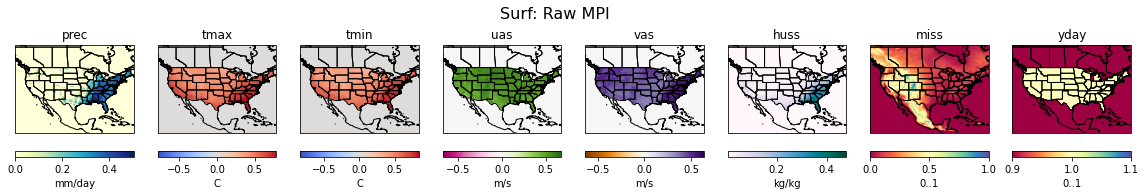

In [85]:
plot_8v_abs_surf_192x256(np.array(samples_era[0]), 'Surf: Raw MPI', vmin, vmax, cc=False)


# Experiments

In [17]:
input_era = samples_era[0:0+mb] 
input_mpi = samples_mpi[0:0+mb] 


In [18]:
samples_era.shape, samples_mpi.shape

(torch.Size([1096, 16, 128, 128]), torch.Size([1096, 16, 128, 128]))

In [19]:
general_encoder(input_era).shape

torch.Size([1, 256, 8, 8])

In [20]:
ss = np.load('/glade/scratch/dkorytin/ssim_closest_mpi2era.npy')

In [21]:
samples_mpi.shape

torch.Size([1096, 16, 128, 128])

### patch reconstruciton

### Tile smoothing

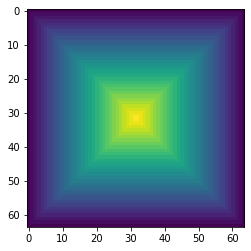

In [150]:
# Kernel#2: Flat-middle kernel
ck = np.zeros((64,64))
for jj in range(64):
    for ii in range(64):
        ck[jj,ii] = min(jj, 63-jj, ii, 63-ii) + 1 # 1 is smallest on border
plt.imshow(ck)

In [151]:
samples_mpi.shape

torch.Size([365, 16, 192, 256])

In [153]:
# normalizer / divisor mask
dm = np.zeros((192,256))
for yy in list(range(0, 192-64, 8))+[192-64]:
    for xx in list(range(0, 256-64, 8))+[256-64]:
        #print(yy,yy+64, xx,xx+64)
        dm[yy:yy+64, xx:xx+64] += ck[:,:]

## replace 0's with 1's (usually on border)
#dm[np.where(ck128==0)] = 1

In [154]:
raw_mpi.shape

(16, 192, 256)

In [158]:
# run 64x64 patch model, sweeping domain with 8 pixel steps
generated_img = np.zeros((1, 16, 192, 256))
for yy in list(range(0, 192-64, 32))+[140-64]:
    for xx in list(range(0, 256-64, 32))+[256-64]:
        print(yy,yy+64, xx,xx+64)        
        input_chunk = samples_mpi[0:1, :,yy:yy+64,xx:xx+64]
        generated_chunk = gen_a.decode(gen_a.encode(input_chunk)[0])
        generated_img[:, :, yy:yy+64, xx:xx+64] +=  np.multiply(generated_chunk[:,0:16,:,:].detach().numpy() , ck[:,:]) 
         
generated_img = np.divide(generated_img,dm[None,None,:,:])
generated_img = generated_img * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
generated_img = generated_img[0]



0 64 0 64
0 64 32 96
0 64 64 128
0 64 96 160
0 64 128 192
0 64 160 224
0 64 192 256
32 96 0 64
32 96 32 96
32 96 64 128
32 96 96 160
32 96 128 192
32 96 160 224
32 96 192 256
64 128 0 64
64 128 32 96
64 128 64 128
64 128 96 160
64 128 128 192
64 128 160 224
64 128 192 256
96 160 0 64
96 160 32 96
96 160 64 128
96 160 96 160
96 160 128 192
96 160 160 224
96 160 192 256
76 140 0 64
76 140 32 96
76 140 64 128
76 140 96 160
76 140 128 192
76 140 160 224
76 140 192 256


In [159]:
generated_img[:,12:12+128,69:69+128].shape

(16, 128, 128)

In [160]:
# raw mpi
input_img_denorm = samples_mpi[0:1] * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
raw_mpi = np.array(input_img_denorm)[0]
raw_mpi.shape

(16, 192, 256)

[-11.361129287067342, -21.458021862045825, 0.00024506348790980626, 245.20290351614403, 2629.891113461883, 5071.2502279432665, -10.465316431365409, -61.59768547640306] [19.59566409929903, 26.37376199930077, 0.011119882200270392, 282.0116048441332, 3136.541498149585, 5824.763751822349, 69.68058732986174, 29.914162391265563]


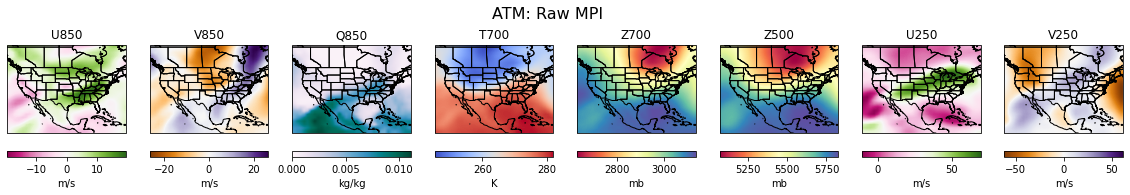

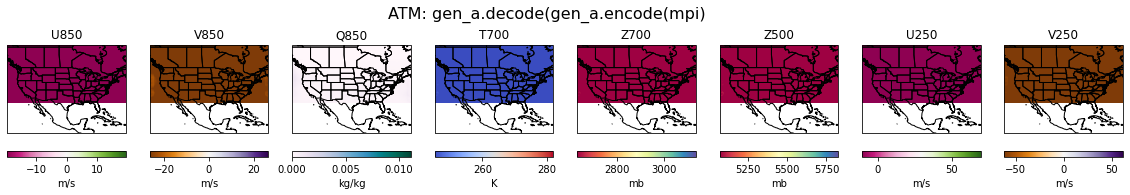

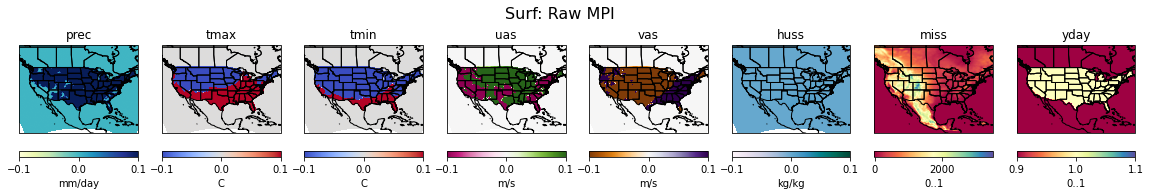

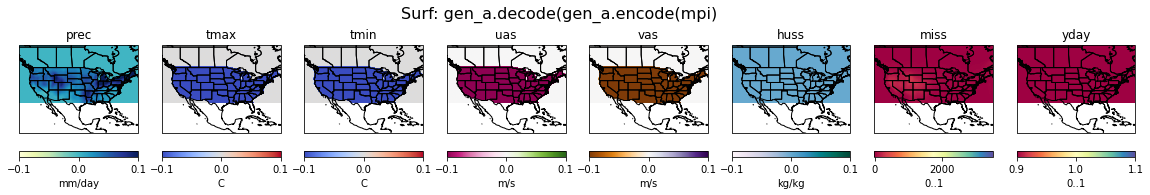

In [161]:
vmin = [raw_mpi[ii].min() for ii in range(16)]
vmax = [raw_mpi[ii].max() for ii in range(16)]
# vmin = [generated_img[ii].min() for ii in range(16)]
# vmax = [generated_img[ii].max() for ii in range(16)]


print(vmin[0:0+8], vmax[0:0+8])
plot_8v_abs_192x256(raw_mpi, 'ATM: Raw MPI', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_192x256(generated_img, 'ATM: gen_a.decode(gen_a.encode(mpi)', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_surf_192x256(raw_mpi, 'Surf: Raw MPI', vmin, vmax, cc=False)
plot_8v_abs_surf_192x256(generated_img, 'Surf: gen_a.decode(gen_a.encode(mpi)', vmin, vmax, cc=False)


<a id='st'></a>
### Simple tiling

In [41]:
#gen_a.train()
#gen_a.eval()


In [147]:
# TODO: do 2x3 maybe 2x4 tiles (each 64x64)  (2022-09-15)
# also update plot routines plot_8v_abs(), etc


generated_img2 = np.zeros((1, 16, 192, 256))

#day_input = samples_mpi[0:1]
day_input = samples_mpi[180:181]

# raw mpi
input_img_denorm = day_input * (minmaxi_mpi[:,1]-minmaxi_mpi[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_mpi[:,0][np.newaxis,:,np.newaxis,np.newaxis]
raw_mpi = np.array(input_img_denorm)[0]

for jj in range(3):
    for kk in range(4): 
        input_chunk = day_input[:, :, jj*64:jj*64+64, kk*64:kk*64+64]
        input_chunk[np.isnan(input_chunk)] = 0.   # extended surface domain has nan's at bottom

        generated_chunk = gen_b.decode(gen_b.encode(input_chunk)[0])
        print(jj, kk, generated_chunk.min(), generated_chunk.max())
        generated_img2[:, :, jj*64:jj*64+64, kk*64:kk*64+64] = generated_chunk[:,0:16,:,:].detach().numpy()


generated_img2 = generated_img2 * (minmaxi_era[:,1]-minmaxi_era[:,0])[np.newaxis,:,np.newaxis,np.newaxis] + minmaxi_era[:,0][np.newaxis,:,np.newaxis,np.newaxis]
generated_img2 = generated_img2[0]


/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1272.)


0 0 tensor(-0.0936, grad_fn=<MinBackward1>) tensor(0.9769, grad_fn=<MaxBackward1>)
0 1 tensor(-0.0490, grad_fn=<MinBackward1>) tensor(1.0913, grad_fn=<MaxBackward1>)
0 2 tensor(-0.0667, grad_fn=<MinBackward1>) tensor(1.0615, grad_fn=<MaxBackward1>)
0 3 tensor(-0.0272, grad_fn=<MinBackward1>) tensor(0.9612, grad_fn=<MaxBackward1>)
1 0 tensor(-0.0096, grad_fn=<MinBackward1>) tensor(0.9335, grad_fn=<MaxBackward1>)
1 1 tensor(-0.0593, grad_fn=<MinBackward1>) tensor(0.9440, grad_fn=<MaxBackward1>)
1 2 tensor(-0.0448, grad_fn=<MinBackward1>) tensor(0.9371, grad_fn=<MaxBackward1>)
1 3 tensor(-0.0511, grad_fn=<MinBackward1>) tensor(0.9319, grad_fn=<MaxBackward1>)
2 0 tensor(-0.0151, grad_fn=<MinBackward1>) tensor(0.8897, grad_fn=<MaxBackward1>)
2 1 tensor(-0.0088, grad_fn=<MinBackward1>) tensor(0.8141, grad_fn=<MaxBackward1>)
2 2 tensor(-0.0463, grad_fn=<MinBackward1>) tensor(0.9141, grad_fn=<MaxBackward1>)
2 3 tensor(-0.1026, grad_fn=<MinBackward1>) tensor(1.8124, grad_fn=<MaxBackward1>)


In [148]:
raw_mpi.shape, generated_img2.shape

((16, 192, 256), (16, 192, 256))

[-11.484774616278628, -13.567247883973323, 0.0017918793530910426, 257.8582751185263, 2795.820083041159, 5271.074229680235, -13.037422984994464, -30.619503088480997] [16.830729127215818, 11.626385327090247, 0.014947591377735998, 288.6634075994489, 3226.0649240176426, 5915.159334498341, 40.15160576404105, 20.294669332986814]


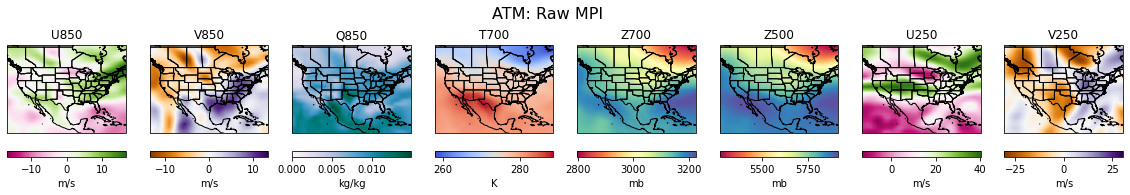

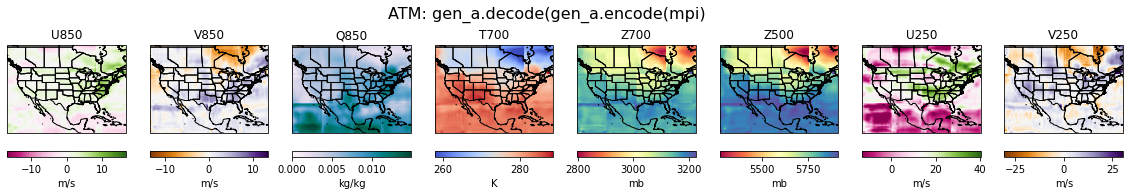

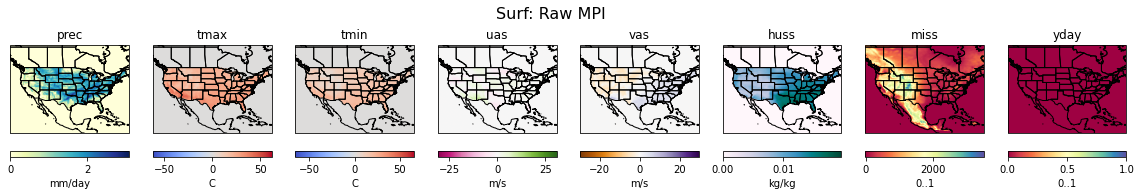

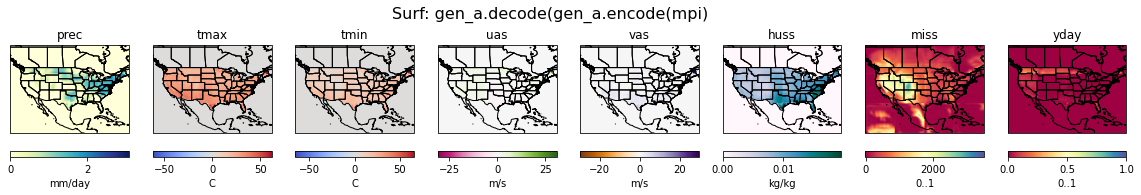

In [149]:
raw_mpi[np.isnan(raw_mpi)] = 0.   # extended surface domain has nan's at bottom
vmin = [raw_mpi[ii].min() for ii in range(16)]
vmax = [raw_mpi[ii].max() for ii in range(16)]
vmin[15]=0
vmax[15]=1


print(vmin[0:0+8], vmax[0:0+8])
plot_8v_abs_192x256(raw_mpi, 'ATM: Raw MPI', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_192x256(generated_img2, 'ATM: gen_a.decode(gen_a.encode(mpi)', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_surf_192x256(raw_mpi, 'Surf: Raw MPI', vmin, vmax, cc=False)
plot_8v_abs_surf_192x256(generated_img2, 'Surf: gen_a.decode(gen_a.encode(mpi)', vmin, vmax, cc=False)


<a id='sf'></a>
### Differences (simple - filterred)

In [138]:
# difference between smoothing and tiling
generated_img3 = generated_img2 - generated_img[:,12:12+128,69:69+128]

vmin = [generated_img3[ii].min() for ii in range(16)]
vmax = [generated_img3[ii].max() for ii in range(16)]

print(vmin[0:0+8], vmax[0:0+8])
plot_8v_abs(generated_img3, 'ATM: gen_a.decode(gen_a.encode(mpi)', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_surf(generated_img3, 'Surf: gen_a.decode(gen_a.encode(mpi)', vmin, vmax, cc=False)


NameError: name 'generated_img' is not defined

[-28.221630490279495, -555.733999192762, -0.13751361685617855, -766.9849194933663, -1290.652775318973, -923.299457228044, -278.98168973602515, -304.91023076675265] [45.58549631726464, 20.37810605483719, 0.007682012730706228, 17.448499219819496, 444.17028314351774, 14378.493149902904, 611.133232418596, 218.7023489480489]


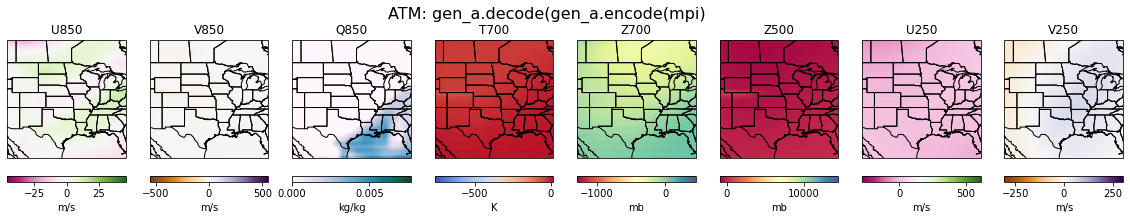

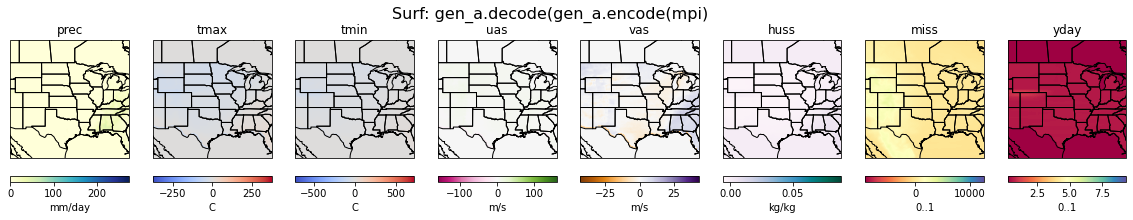

In [300]:
# raw_mpi - 8x8tiling
generated_img3 = raw_mpi - generated_img[:,12:12+128,69:69+128]

# vmin = [generated_img3[ii].min() for ii in range(16)]
# vmax = [generated_img3[ii].max() for ii in range(16)]

print(vmin[0:0+8], vmax[0:0+8])
plot_8v_abs(generated_img3, 'ATM: gen_a.decode(gen_a.encode(mpi)', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_surf(generated_img3, 'Surf: gen_a.decode(gen_a.encode(mpi)', vmin, vmax, cc=False)


[-28.221630490279495, -555.733999192762, -0.13751361685617855, -766.9849194933663, -1290.652775318973, -923.299457228044, -278.98168973602515, -304.91023076675265] [45.58549631726464, 20.37810605483719, 0.007682012730706228, 17.448499219819496, 444.17028314351774, 14378.493149902904, 611.133232418596, 218.7023489480489]


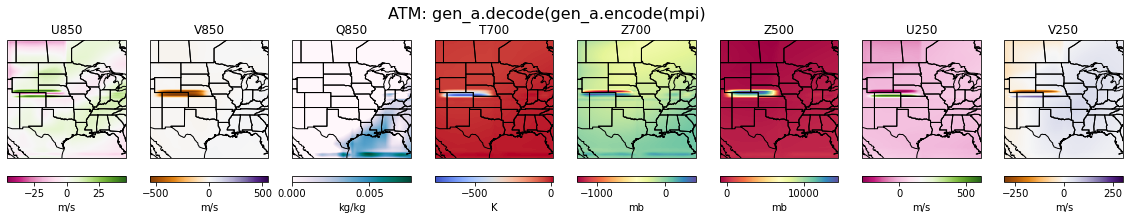

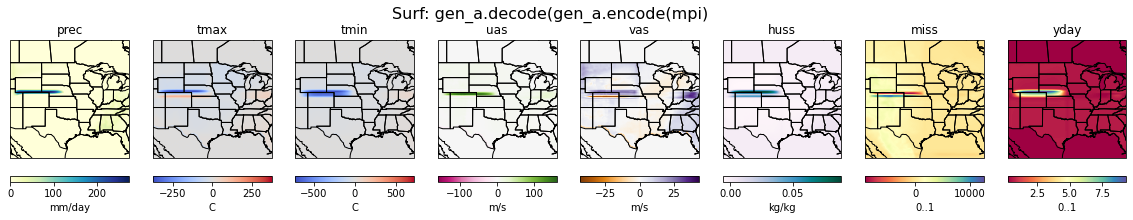

In [299]:
# raw_mpi - 4 tiles
generated_img3 = raw_mpi - generated_img2

vmin = [generated_img3[ii].min() for ii in range(16)]
vmax = [generated_img3[ii].max() for ii in range(16)]

print(vmin[0:0+8], vmax[0:0+8])
plot_8v_abs(generated_img3, 'ATM: gen_a.decode(gen_a.encode(mpi)', vmin[0:0+8], vmax[0:0+8], cc=False)
plot_8v_abs_surf(generated_img3, 'Surf: gen_a.decode(gen_a.encode(mpi)', vmin, vmax, cc=False)


# test on picture domain